# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu

In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR = "/content/drive/MyDrive/Colab Notebooks/Fintech/Pt2/"
os.chdir(DIR)

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [4]:
df_news = pd.read_csv('data/df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [5]:
print(df_news.columns)

Index(['TICKER', 'TITLE', 'SUMMARY', 'PUBLICATION_DATE', 'PROVIDER', 'URL'], dtype='object')


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

In [6]:
# CODE HERE
# Use as many coding cells as you need

# STEP 1

df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' ' + df_news['SUMMARY']

In [7]:
# STEP 2

model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# STEP 3

class CustomVectorStore:
    def __init__(self, model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must be same length"
        self.model = model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = model.encode(documents, convert_to_numpy=True)

    def search(self, query, k=5, metadata_filter=None):
        if metadata_filter:
            filtered = [
                (doc, meta, emb)
                for doc, meta, emb in zip(self.documents, self.metadata, self.embeddings)
                if metadata_filter(meta)
            ]
            if not filtered:
                return []
            docs, metas, embs = zip(*filtered)
        else:
            docs, metas, embs = self.documents, self.metadata, self.embeddings

        query_embedding = self.model.encode([query], convert_to_numpy=True)
        similarities = cosine_similarity(query_embedding, np.vstack(embs))[0]
        top_k_idx = similarities.argsort()[::-1][:k]
        results = [(docs[i], metas[i], similarities[i]) for i in top_k_idx]
        return results



## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


In [9]:
# CODE HERE
# Use as many coding cells as you need

# STEP 1

documents = df_news['EMBEDDED_TEXT'].tolist()

In [10]:
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')

In [11]:
store = CustomVectorStore(model, documents, metadata)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [12]:
results = store.search("Apple earnings", k=3)

for doc, meta, score in results:
    print(f"\n- Text: {doc}\n- Metadata: {meta}\n- Score: {score:.4f}")


- Text: Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain. Thursday morning, Aptiv reported first-quarter earnings per share of $1.69 from sales of $4.8 billion in sales. Wall Street was looking for EPS of $1.53 from sales of $4.8 billion.
- Metadata: {'PUBLICATION_DATE': datetime.date(2025, 5, 1), 'TICKER': 'APTV', 'PROVIDER': 'Barrons.com'}
- Score: 0.5717

- Text: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, but a minor dip in net income and earnings per share. Alongside this, the company reaffirmed its quarterly dividend of $1.03 per share. These updates coincide with a 4.5% price increase over the week, which aligns with broader market gains of 5.2%. Despite fluctuations in major indices due to economic data and earnings reports from numerous companies,...
- Metadata: {'PUBLICATION_DATE': datetime.dat

## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


In [13]:
# CODE HERE
# Use as many coding cells as you need

results = store.search("AI announcement", k=50)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [14]:
for i, (doc, meta, score) in enumerate(results, start=1):
    print(f"\n -Result #{i}:")
    print(f" -TICKER: {meta['TICKER']}")
    print(f" -PUBLICATION_DATE: {meta['PUBLICATION_DATE']}")
    print(f" -PROVIDER: {meta['PROVIDER']}")
    print(f" -Similarity Score: {score:.4f}")
    print(f" -Document Text:\n{doc}")
    print("-" * 80)



 -Result #1:
 -TICKER: ADBE
 -PUBLICATION_DATE: 2025-05-27
 -PROVIDER: Investor's Business Daily
 -Similarity Score: 0.5567
 -Document Text:
AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
--------------------------------------------------------------------------------

 -Result #2:
 -TICKER: JKHY
 -PUBLICATION_DATE: 2025-03-17
 -PROVIDER: Insider Monkey
 -Similarity Score: 0.5467
 -Document Text:
Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
-------------------------------------

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [15]:
# CODE HERE
# Use as many coding cells as you need

tickers = [meta['TICKER'] for _, meta, _ in results]
ticker_counts = Counter(tickers)

In [16]:
top_tickers = ticker_counts.most_common()
for ticker, count in top_tickers:
    print(f"{ticker}: {count}")

PLTR: 5
BKR: 3
AMD: 3
CTSH: 3
QCOM: 2
META: 2
AMZN: 2
MSFT: 2
EXPE: 2
INTC: 2
ADBE: 1
JKHY: 1
WSM: 1
RSG: 1
CEG: 1
SMCI: 1
ORCL: 1
GOOGL: 1
GOOG: 1
INTU: 1
NVDA: 1
YUM: 1
ABNB: 1
PYPL: 1
NFLX: 1
CRM: 1
ROK: 1
NOW: 1
CSCO: 1
DELL: 1
HPQ: 1
FFIV: 1
IT: 1
KMX: 1


* PLTR (Palantir) appearing most frequently (5 times).
* BKR, AMD, CTSH, QCOM, META, AMZN, MSFT, EXPE and INTC appears more than once.
* It's somewhat surprising to see EXPE (Expedia) among the top TICKERs, which suggests possible AI announcements in travel tech.


### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

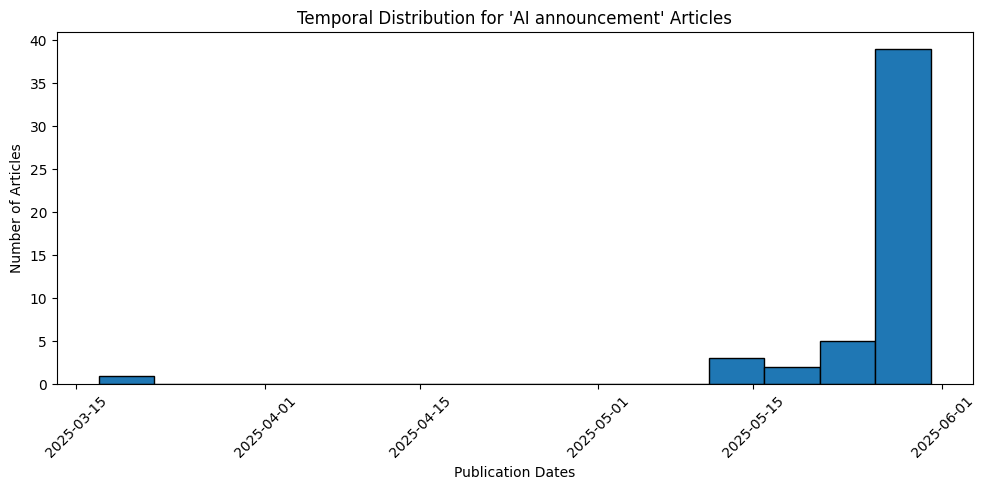

In [17]:
# CODE HERE
# Use as many coding cells as you need

dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]

plt.figure(figsize=(10, 5))
plt.hist(dates, bins=15, edgecolor='black')
plt.title("Temporal Distribution for 'AI announcement' Articles")
plt.xlabel("Publication Dates")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* The publication dates range from March 15, 2025, to May 31, 2025.
* The distribution is clearly not even. Nearly 80% of the articles were published in the last 10–15 days of May.
* This suggests a recent surge in AI interest or news coverage, possibly driven by product launches or the announcement of new AI features. It may also be related to increased market focus or emerging trends tied to AI adoption.

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [18]:
# CODE HERE
# Use as many coding cells as you need

embeddings = store.embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [19]:
# CODE HERE
# Use as many coding cells as you need

dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings)

In [20]:
query = "AI announcement"
query_embedding = model.encode([query], convert_to_numpy=True)
query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

k = 5
scores, indices = index.search(query_embedding, k)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [21]:
for i, idx in enumerate(indices[0]):
    print(f"\nResult #{i+1}")
    print(f"TICKER: {meta['TICKER']} | PROVIDER: {meta['PROVIDER']} | DATE: {meta['PUBLICATION_DATE']}")
    print(f"Document: {documents[idx]}")
    print(f"Score (cosine similarity): {scores[0][i]:.4f}")


Result #1
TICKER: BKR | PROVIDER: Insider Monkey | DATE: 2025-05-30
Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
Score (cosine similarity): 0.5567

Result #2
TICKER: BKR | PROVIDER: Insider Monkey | DATE: 2025-05-30
Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
Score (cosine similarity): 0.5467

Result #3
TICKER: BKR | PROVIDER: Insider Monkey | DATE: 2025-05-30
Document: Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake Shares of both Palan

### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [22]:
# CODE HERE
# Use as many coding cells as you need

class FaissVectorStore:
    def __init__(self, model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must match"

        self.model = model
        self.documents = documents
        self.metadata = metadata

        self.embeddings = model.encode(documents, convert_to_numpy=True)
        self.embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)

        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        self.index.add(self.embeddings)

    def search(self, query, k=5, metadata_filter=None):
        if metadata_filter:
            filtered = [
                (doc, meta, emb)
                for doc, meta, emb in zip(self.documents, self.metadata, self.embeddings)
                if metadata_filter(meta)
            ]
            if not filtered:
                return []

            docs, metas, embs = zip(*filtered)
            embs = np.array(embs)
            temp_index = faiss.IndexFlatIP(embs.shape[1])
            temp_index.add(embs)
        else:
            docs, metas = self.documents, self.metadata
            temp_index = self.index

        query_emb = self.model.encode([query], convert_to_numpy=True)
        query_emb = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)

        scores, indices = temp_index.search(query_emb, k)
        results = []
        for idx, i in enumerate(indices[0]):
          if i < len(docs):
            results.append((docs[i], metas[i], scores[0][idx]))

        return results

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [23]:
# CODE HERE
# Use as many coding cells as you need

store_faiss = FaissVectorStore(model, documents, metadata)
results = store_faiss.search("AI announcement", k=50)

for i, (doc, meta, score) in enumerate(results, 1):
    print(f"\nResult #{i}")
    print(f"TICKER: {meta['TICKER']}")
    print(f"DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"Score: {score:.4f}")
    print(f"Full Text:\n{doc}")
    print("-" * 80)


Result #1
TICKER: ADBE
DATE: 2025-05-27
PROVIDER: Investor's Business Daily
Score: 0.5567
Full Text:
AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
--------------------------------------------------------------------------------

Result #2
TICKER: JKHY
DATE: 2025-03-17
PROVIDER: Insider Monkey
Score: 0.5467
Full Text:
Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
--------------------------------------------------------------------------------

Result #3
TICKER: PLTR
DATE: 2025-0

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [24]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'

]

In [25]:
# CODE HERE
# Use as many coding cells as you need

for query in test_queries:
    print(f"\nQuery: {query}")
    print("="*80)

    # Custom Vector Store
    custom_results = store.search(query, k=5)
    print("CustomVectorStore Results:")
    for i, (doc, meta, score) in enumerate(custom_results, 1):
        print(f"\n{i}. {doc[:200]}...")

    # FAISS Vector Store
    faiss_results = store_faiss.search(query, k=5)
    print("\nFaissVectorStore Results:")
    for i, (doc, meta, score) in enumerate(faiss_results, 1):
        print(f"\n{i}. {doc[:200]}...")

    print("\n" + "-"*80 + "\n")


Query: Stock price drop
CustomVectorStore Results:

1. 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, its stock price has dropped 21.6% to $195 per shar...

2. 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24.3% to a new 52-week low of $224.50 per share. Thi...

3. Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in the afternoon session after the major indices pulled...

4. 3 Industrials Stocks Walking a Fine Line Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this role also comes with a demand profile tethered to ...

5. Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note Kroger (KR) closed at $67.83 in the latest

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


CustomVectorStore Results:

1. Chevron to layoff approximately 200 employees in Texas in 2025 Chevron plans to lay off 200 employees at locations in Midland, Texas as part of a global workforce reduction of up to 20% by 2026....

2. FedEx Plans More Than 300 Layoffs At Texas Facility The logistics giant said impacted workers may be offered other positions with the company....

3. Chevron to implement around 800 job cuts in Texas Chevron previously disclosed plans to lay off 600 California workers starting on 1 June, according to a March report....

4. Chevron Confirms 200 Permian Layoffs—Not 800 Chevron has confirmed the Texas Workforce Commission mistakenly reported the number of layoffs in Midland as 800. ...

5. Georgia-Pacific, Greif, Silgan detailed layoff plans in May Amcor and International Paper also disclosed forthcoming changes as they integrate recent acquisitions. LanzaTech, which has worked to creat...

FaissVectorStore Results:

1. Chevron to layoff approximately 200 empl

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


CustomVectorStore Results:

1. How the 10-year yield affects REITs Interest rate-sensitive REITs (Real Estate Investment Trusts) are set to benefit from the Federal Reserve's anticipated easing of monetary policy. Richard Anderson,...

2. NEM, FNV, and WPM Primed for Gold Rush 2.0 as Geopolitics Fuel Hard Asset Boom Amid rising geopolitical tensions, persistent inflation concerns, and growing skepticism about long-term fiscal disciplin...

3. Bitcoin price slips as Fed minutes flag US inflation risks The Federal Reserve’s May policy meeting revealed mounting concern over persistent US inflation and the potential for economic slowdown....

4. Fed Leaves Interest Rates Unchanged: 4 Low-Beta Utility Stocks to Buy Markets are likely to remain volatile. Utility stocks, which are considered defensive, such as AES, DTE, ATO and AWK are safe bets...

5. Fed Leaves Interest Rates Unchanged: 4 Low-Beta Utility Stocks to Buy Markets are likely to remain volatile. Utility stocks, which are conside

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

In the comparison of the top-5 retrieved results across all enumerated test queries, CustomVectorStore and FaissVectorStore returned the same headlines for each query. This indicates that both systems are consistent in capturing semantic similarity, despite relying on different underlying mechanisms for similarity search.

The reason the results are so similar is because both systems use the same sentence transformer model (all-MiniLM-L6-v2) to generate embeddings and the cosine similarity as the distance metric.

Since the embeddings and similarity metric are identical, and the dataset is relatively small, it is expected that the top matches are the same. Minor differences might still occur in larger datasets or under filtered conditions, but in this case, both systems align very closely.

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [26]:
# CODE HERE
# Use as many coding cells as you need

model_mini = SentenceTransformer('all-MiniLM-L6-v2')
model_mpnet = SentenceTransformer('all-mpnet-base-v2')

In [27]:
store_mini = CustomVectorStore(model_mini, documents, metadata)
store_mpnet = CustomVectorStore(model_mpnet, documents, metadata)

In [28]:
for query in test_queries:
    print(f"\nQuery: {query}")
    print("=" * 80)

    # MINI
    results_mini = store_mini.search(query, k=5)
    print("Model: all-MiniLM-L6-v2")
    for i, (doc, meta, score) in enumerate(results_mini, 1):
        print(f"\n{i}. {doc[:200]}...")

    # MPNET
    results_mpnet = store_mpnet.search(query, k=5)
    print("\nModel: all-mpnet-base-v2")
    for i, (doc, meta, score) in enumerate(results_mpnet, 1):
        print(f"\n{i}. {doc[:200]}...")

    print("\n" + "-" * 80 + "\n")



Query: Stock price drop
Model: all-MiniLM-L6-v2

1. 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, its stock price has dropped 21.6% to $195 per shar...

2. 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24.3% to a new 52-week low of $224.50 per share. Thi...

3. Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in the afternoon session after the major indices pulled...

4. 3 Industrials Stocks Walking a Fine Line Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this role also comes with a demand profile tethered to ...

5. Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note Kroger (KR) closed at $67.83 in the latest tr

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Model: all-MiniLM-L6-v2

1. Chevron to layoff approximately 200 employees in Texas in 2025 Chevron plans to lay off 200 employees at locations in Midland, Texas as part of a global workforce reduction of up to 20% by 2026....

2. FedEx Plans More Than 300 Layoffs At Texas Facility The logistics giant said impacted workers may be offered other positions with the company....

3. Chevron to implement around 800 job cuts in Texas Chevron previously disclosed plans to lay off 600 California workers starting on 1 June, according to a March report....

4. Chevron Confirms 200 Permian Layoffs—Not 800 Chevron has confirmed the Texas Workforce Commission mistakenly reported the number of layoffs in Midland as 800. ...

5. Georgia-Pacific, Greif, Silgan detailed layoff plans in May Amcor and International Paper also disclosed forthcoming changes as they integrate recent acquisitions. LanzaTech, which has worked to creat...

Model: all-mpnet-base-v2

1. Freight industry layoffs surge across Califo

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Model: all-mpnet-base-v2

1. JPMorgan CEO Dimon backs US taxing carried interest, warns of bond market trouble (Reuters) -JPMorgan Chase CEO Jamie Dimon said on Friday that the U.S. should be taxing carried interest, joining the ...

2. Traders Brace for Treasury 10-Year Yield at 5% as Mood Sours (Bloomberg) -- Traders are piling into bets that long-term Treasury yields will surge on concerns over the US government’s swelling debt an...

3. Trump announces trade deal, BoE lowers Bank Rate: Morning Buzz The major averages were sharply higher near noon amid increased optimism around trade, as well as a decrease in U.S. initial jobless clai...

4. Trump announces trade deal, BoE lowers Bank Rate: Morning Buzz The major averages were sharply higher near noon amid increased optimism around trade, as well as a decrease in U.S. initial jobless clai...

5. US Treasuries Slide as Solid Jobs Market Gives Fed Room on Rates (Bloomberg) -- US Treasuries fell after stronger-than-expected US employm

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Model: all-MiniLM-L6-v2

1. 3 Crypto-Centric Stocks in Focus as Bitcoin Resumes Its Rally Bitcoin hovers near $110K as crypto sentiment surges. V, PYPL, and CLSK emerge as top stock picks with rising earnings outlooks....

2. Cryptocurrency Prices And News: Bitcoin Hovers Near Record High, Miners Join Rally Cryptocurrency News:  Cryptocurrency prices have been mixed this week after bitcoin surged to a new record high on Ma...

3. Bitcoin Price Falls. Key Crypto Conference Fails to Lift Digital Coins. Bitcoin’s  price edged down despite a flurry of crypto news, including an endorsement by Vice President JD Vance in a speech at ...

4. Robinhood vs. Coinbase: Why One Stock Is a Much Bigger Winner The boom in Bitcoin is driving both stocks. But Robinhood is on a meteoric rise because of the very obvious rebound in riskier stocks....

5. 2 Stocks Down 30% and 18% to Buy Hand Over Fist Block's expanding suite of services should allow it to make headway within its vast addressable market.  P

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

After evaluating the top 5 retrieved documents across all test queries using all-MiniLM-L6-v2 and all-mpnet-base-v2, it appears that all-mpnet-base-v2 consistently returns more precise and diverse results, but takes more time to execute. While both models retrieved semantically relevant documents, there are key differences worth noting:

* For the query "stock price drop", MiniLM returned several articles with similar phrasing (“got torched…”), while MPNet included a broader set of companies (e.g., HP, Uber, Starbucks) and more varied contexts, indicating better generalization.

* In "layoffs", MiniLM focused mostly on Chevron and FedEx-related news, showing some redundancy, while MPNet brought in freight industry, Amazon, and Apple mentions, offering a wider view of layoff events.

* In "mergers and acquisitions", both models captured key M&A articles, but MPNet included a Bloomberg analysis and Kraft Heinz strategic planning — showing it can retrieve higher-level financial reporting.

* For "Fed interest rate", MPNet highlighted content discussing Treasury yields, JPMorgan CEO statements, and market reactions, whereas MiniLM focused more narrowly on utilities and REITs, with repeated entries.

* On "cryptocurrency", both retrieved similar items, but MPNet added CME Group’s crypto offering and Fifth Third Bank’s investment strategy, giving it a more comprehensive view of crypto finance.

Overall, MPNet showed greater variety, less redundancy, and a broader financial perspective in several queries. Its richer embedding space likely contributes to better semantic understanding, especially in finance-related topics.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

Vector normalization ensures that cosine similarity reflects true semantic similarity. In the CustomVectorStore, normalization is handled internally by the cosine_similarity function from scikit-learn, so manual normalization is not necessary. In contrast, the FaissVectorStore uses IndexFlatIP (inner product) for similarity search, which requires manual normalization of vectors to unit length in order to make the inner product behave like cosine similarity.


### **Q6.**  What would happen if vectors were not normalized before indexing?

If vectors were not normalized before indexing, the inner product in FAISS would no longer represent cosine similarity. This means the similarity scores would be influenced not only by the direction (semantic meaning) of the vectors, but also by their magnitude (length).




## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


For a production-scale search system, I would rather choose the FAISS-based implementation (FaissVectorStore). FAISS is specifically optimized for large scale and efficient similarity search. It supports fast approximate nearest neighbor search, GPU acceleration, and scalable indexing techniques, making it ideal for real-time or high-volume applications.


### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

The FAISS based implementation will scale significantly better. This is because FAISS is designed for high-performance similarity search on large-scale datasets as described above. It supports efficient indexing structures, such as inverted files and HNSW graphs, and can leverage GPU acceleration to handle millions of vectors with low latency.